In [91]:
from IPython import display

import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
import glob
import os
import tensorflow_probability as tfp
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
import time
import copy
import re
from sklearn import neighbors
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

pd.options.mode.chained_assignment = None
# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
tf.config.run_functions_eagerly(True)

In [2]:
directory = "/home/ggdhines/bear/"

In [4]:
def plot_character(character_df,index):
    row = character_df.loc[index]
    img = cv2.imread(directory+row["fname"])

    tile = img[row.top:row.bottom,row.left:row.right]

    _ = plt.imshow(tile)

In [5]:
tiles = []
all_characters = []

master_list = [chr(ord('0')+i) for i in range(10)]

for fname in os.listdir(directory):
    match = re.search("(.*)-(\d+)-(\d+)\-(\d*)_ocr_ready.png",fname)
    if match is None:
        continue
        
    print(fname,end="\r")
        
    csv_file = fname[:-13] + "ocr.csv"
    img = cv2.imread(directory+fname,0)
    
    characters = pd.read_csv(directory+csv_file,delimiter=" ",error_bad_lines=False, engine="python",quoting=3)
    
    m1 = characters["confidence"] > 95
    m2 = characters["character"].isin(master_list)
    
    df = characters[m1]
    
    max_darkness = []
    for _,row in df.iterrows():
        tile = img[row.top:row.bottom,row.left:row.right]
        resized_tile = cv2.resize(tile,(28,28))
        max_darkness.append(np.min(tile))
        tiles.append(resized_tile)
        
    df["max_darkness"] = max_darkness
    df["fname"] = fname
    
    df["area"] = (df["right"] - df["left"]) * (df["bottom"] - df["top"])
    all_characters.append(df)
    
all_characters = pd.concat(all_characters,ignore_index=True)
tiles = np.asarray(tiles)
s = tiles.shape
tiles = tiles.reshape((s[0],s[1],s[2],1))

Some ink pixels are fairly bright (barely indistinguishable from paper pixels), and so we set our threshold for paper/ink fairly high. However, for a full character, there should be at least some dark pixels, i.e. the bright ink pixels are on the boundary between ink and paper. The interior of the character will be dark. So if Tesseract finds a character where every pixel is bright, we should be worried.

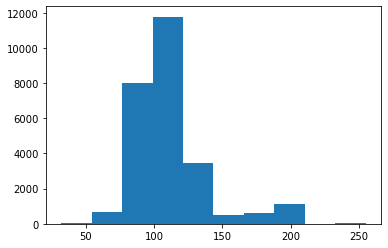

In [6]:
_ = plt.hist(all_characters["max_darkness"])

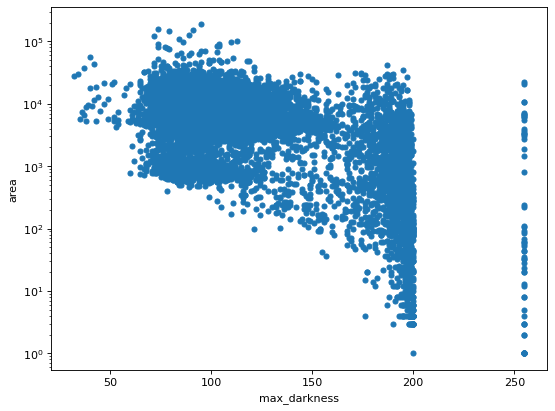

In [7]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
all_characters.plot.scatter(x="max_darkness",y="area",ax=ax)
ax.set_yscale('log')
plt.show()

In [8]:
m = all_characters["max_darkness"] <= 170
all_characters[m].sort_values("max_darkness",ascending=False).head(5)

,character,confidence,left,top,right,bottom,max_darkness,fname,area
25951,L,99.168793,3498,5549,3547,5636,170,Bear-AG-29-1940-01-49_ocr_ready.png,4263
6771,N,99.295258,2960,8184,3021,8309,170,Bear-AG-29-1940-01-15_ocr_ready.png,7625
1782,’,95.788155,2922,8453,2931,8467,170,Bear-AG-29-1940-01-21_ocr_ready.png,126
11599,.,98.890160,3170,3228,3181,3237,170,Bear-AG-29-1940-01-17_ocr_ready.png,99
20920,1,99.446388,5713,2897,5726,2901,170,Bear-AG-29-1940-01-65_ocr_ready.png,52


Note that all of these characters are completely suspect, but Tesseract still feels fairly confident. Also, for most the area seems far too small.

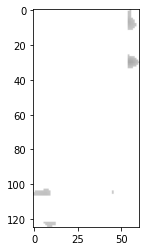

In [9]:
plot_character(all_characters,6771)

We can play around with the threshold and see that requiring max_darkness <= 170 seems reasonable. (Might be nice to create a more automated filter in the future.) From below, we see that this filters out about 7% of the characters.

In [10]:
darkness_mask = all_characters["max_darkness"] <= 170
s1 = all_characters[darkness_mask].shape[0]
s2 = all_characters.shape[0]
print(s1/s2)

0.9333536098543892


Next, characters which are way too big or small need to be examined. Filtering out impossibly small characters is straightforward. However, it is a bit more complicated with bigger characters. These often include the correct character plus a whole bunch more. We will filter them out for now, since all of this is going to be fed into the autoencoder which benefits from characters being as similar as possible. However, we will want to feed these "characters" through the website to have the bounding boxes correct, whereas we can just drop the overly small characters completely.

In [11]:
filtered_characters = all_characters[darkness_mask]
filtered_characters.sort_values("area")

,character,confidence,left,top,right,bottom,max_darkness,fname,area
22900,"""",97.877411,3747,5989,3759,5992,157,Bear-AG-29-1940-01-71_ocr_ready.png,36
558,t,95.463089,3605,5144,3619,5147,155,Bear-AG-29-1940-01-11_ocr_ready.png,42
20920,1,99.446388,5713,2897,5726,2901,170,Bear-AG-29-1940-01-65_ocr_ready.png,52
4072,.,97.127541,2669,4753,2678,4759,167,Bear-AG-29-1940-01-13_ocr_ready.png,54
9279,S,99.326218,6452,3600,6456,3616,169,Bear-AG-29-1940-01-57_ocr_ready.png,64
...,...,...,...,...,...,...,...,...,...
6682,0,98.340630,5850,7821,6843,7950,89,Bear-AG-29-1940-01-15_ocr_ready.png,128097
17463,0,98.725624,5990,8407,6872,8573,79,Bear-AG-29-1940-01-45_ocr_ready.png,146412
6006,y,99.539673,6034,1413,6823,1607,91,Bear-AG-29-1940-01-15_ocr_ready.png,153066
14674,8,97.903999,3546,7941,4722,8074,74,Bear-AG-29-1940-01-31_ocr_ready.png,156408


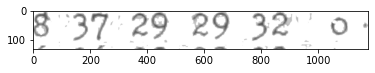

In [12]:
plot_character(all_characters,14674)

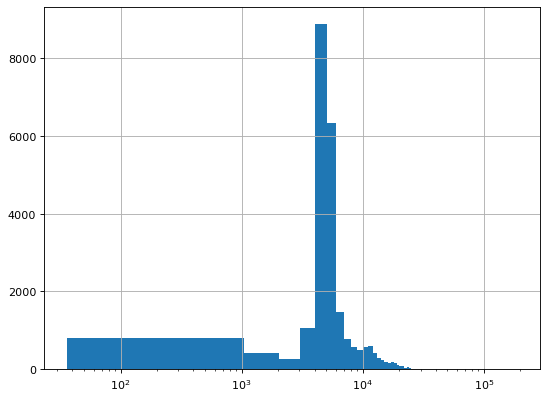

In [13]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
bins = range(filtered_characters["area"].min(),filtered_characters["area"].max(),1000)
filtered_characters["area"].hist(bins=bins)
ax.set_xscale('log')
plt.show()

In [14]:
m = filtered_characters["area"] <= 10000
filtered_characters[m].sort_values("area",ascending=False).head(5)

,character,confidence,left,top,right,bottom,max_darkness,fname,area
14774,3,99.534401,4270,8303,4370,8403,77,Bear-AG-29-1940-01-31_ocr_ready.png,10000
24215,9,98.949043,5941,3736,6041,3836,99,Bear-AG-29-1940-01-41_ocr_ready.png,10000
4213,2,99.562996,3192,7733,3317,7813,103,Bear-AG-29-1940-01-13_ocr_ready.png,10000
14149,5,99.235985,5958,3152,6057,3253,97,Bear-AG-29-1940-01-31_ocr_ready.png,9999
13139,3,99.136246,5961,8782,6062,8881,111,Bear-AG-29-1940-01-51_ocr_ready.png,9999


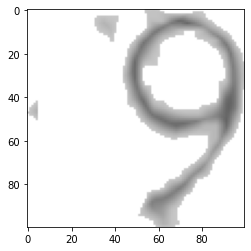

In [15]:
plot_character(all_characters,24215)

An upper bound of 1000 for area seems good, but we could probably reduce it a bit too if we wanted to

In [16]:
m = filtered_characters["area"] > 2000
filtered_characters[m].sort_values("area").head(5)

,character,confidence,left,top,right,bottom,max_darkness,fname,area
2177,.,96.160172,5823,3816,5910,3839,170,Bear-AG-29-1940-01-63_ocr_ready.png,2001
12152,w,97.120468,5430,7954,5456,8031,131,Bear-AG-29-1940-01-17_ocr_ready.png,2002
8480,"""",96.386330,2396,4686,2443,4729,85,Bear-AG-29-1940-01-5_ocr_ready.png,2021
636,.,98.961739,3392,7657,3438,7701,77,Bear-AG-29-1940-01-11_ocr_ready.png,2024
8509,"""",98.251060,2399,5041,2445,5085,75,Bear-AG-29-1940-01-5_ocr_ready.png,2024


The bounding box below is definitely too small, but the character is correct. So we may need to follow up on such bounding boxes in the website. (Also check to see if we have overlapping bounding boxes.)

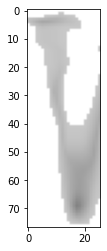

In [17]:
plot_character(all_characters,12152)

In [18]:
m1 = filtered_characters["area"] <= 10000
m2 = filtered_characters["area"] >= 2000

double_filtered_characters = filtered_characters[m1&m2]
s1 = double_filtered_characters.shape[0]
s2 = all_characters.shape[0]
print(s1/s2)

0.7542105463255142


In [20]:
resampled.head()

,character,confidence,left,top,right,bottom,max_darkness,fname,area
21713,!,95.721321,7343,8461,7434,8523,49,Bear-AG-29-1940-01-65_ocr_ready.png,5642
21713,!,95.721321,7343,8461,7434,8523,49,Bear-AG-29-1940-01-65_ocr_ready.png,5642
21713,!,95.721321,7343,8461,7434,8523,49,Bear-AG-29-1940-01-65_ocr_ready.png,5642
21346,!,99.320824,1984,4914,2030,4987,99,Bear-AG-29-1940-01-65_ocr_ready.png,3358
21713,!,95.721321,7343,8461,7434,8523,49,Bear-AG-29-1940-01-65_ocr_ready.png,5642


In [86]:
def split(character_df,tiles):
    train_df,test_df = train_test_split(character_df, test_size=0.25, random_state=0)

    train_images = tiles[train_df.index]
    # we no longer need this index wrt to the original dataframe
    train_df = train_df.reset_index(drop=True)

    test_images = tiles[test_df.index]
    test_df = test_df.reset_index(drop=True)

    train_images = train_images / 255
    test_images = test_images / 255

    # sanity check
    assert np.max(train_images) == 1
    return train_images,test_images,train_df,test_df
    

In [112]:
train_images,test_images,train_df,test_df = split(double_filtered_characters,tiles)

character                                         9
confidence                                  99.2465
left                                           5734
top                                            3619
right                                          5790
bottom                                         3716
max_darkness                                     99
fname           Bear-AG-29-1940-01-43_ocr_ready.png
area                                           5432
Name: 0, dtype: object

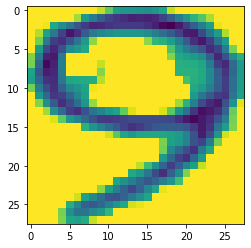

In [113]:
display.display(train_df.iloc[0])
plt.imshow(train_tiles[0])

The following code is taken from https://www.tensorflow.org/tutorials/generative/cvae

In [83]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    



def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    # not sure why the following had to be added in
    x = tf.cast(x, tf.float32)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [79]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [88]:
def train_model(train_images,test_images,model_name,epochs):
    # set the dimensionality of the latent space to a plane for visualization later
    latent_dim = 2
    num_examples_to_generate = 16
    batch_size = 64
    
    train_size = train_images.shape[0]
    test_size = test_images.shape[0]


    train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                     .shuffle(train_size).batch(batch_size))
    test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                    .shuffle(test_size).batch(batch_size))

    assert batch_size >= num_examples_to_generate
    for test_batch in test_dataset.take(1):
        test_sample = test_batch[0:num_examples_to_generate, :, :, :]
    
    # keeping the random vector constant for generation (prediction) so
    # it will be easier to see the improvement.
    random_vector_for_generation = tf.random.normal(
        shape=[num_examples_to_generate, latent_dim])
    model = CVAE(latent_dim)

    generate_and_save_images(model, 0, test_sample)
    optimizer = tf.keras.optimizers.Adam(1e-4)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_step(model, train_x, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()


        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {},time elapse for current epoch: {}'
            .format(epoch, elbo,end_time - start_time))
        generate_and_save_images(model, epoch, test_sample)
        
        weights_file = f"{directory}weights_{model_name}"
        if not os.path.exists(weights_file):
            model.save_weights(weights_file)
        else:
            model.load_weights(weights_file)
            
    return model

We have a very biased data set, so we'll check to see if reweighting the training and test set improves things.

Epoch: 75, Test set ELBO: -237.10824584960938,time elapse for current epoch: 10.402828454971313


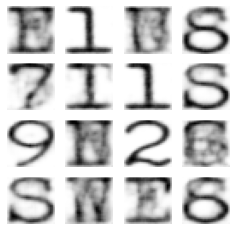

In [81]:
base_model = train_model(train_images,test_images,"base",75)

To test our CVAE, we will take a test example and see how well the autoencoder corrects the image.

Epoch: 75, Test set ELBO: -241.5244140625,time elapse for current epoch: 7.741485357284546


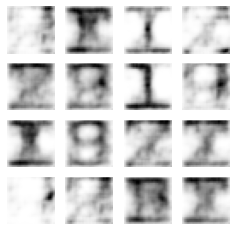

In [94]:
resampled = double_filtered_characters.groupby("character").sample(n=100,replace=True)
resampled_train_images,resampled_test_images,resampled_train_df,resampled_test_df = split(resampled,tiles)
resampled_model = train_model(resampled_train_images,resampled_test_images,"resampled",75)

We could always increase the sameple size for the reweighted train/test set, but the initial results shown below are not promising.

9


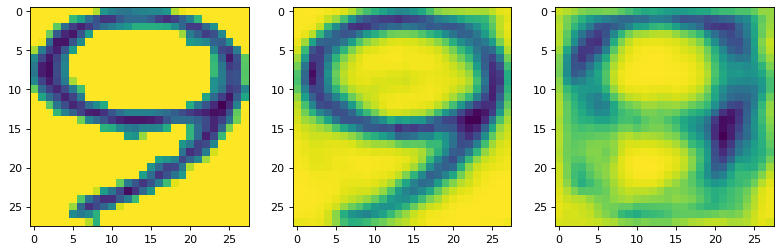

In [98]:
index = 4

print(test_df.loc[index,"character"])

fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(131)
ax.imshow(test_images[index,:,:,0])

ax = fig.add_subplot(132)
a,b = base_model.encode(test_images[index:index+1,:,:,:])
z = base_model.reparameterize(a,b)
x = base_model.decode(z,apply_sigmoid=True)
ax.imshow(x[0,:,:,0])

ax = fig.add_subplot(133)
a,b = resampled_model.encode(test_images[index:index+1,:,:,:])
z = resampled_model.reparameterize(a,b)
x = resampled_model.decode(z,apply_sigmoid=True)
ax.imshow(x[0,:,:,0])

plt.show()

In [117]:
x = []
y = []
characters = []
indices = []
confidence = []
of_interest = []

for index in range(test_images.shape[0]):
    print(index,end="\r")

    original = test_images[index:index+1,:,:,:]

    a,b = base_model.encode(original)
    z = base_model.reparameterize(a,b)
    
    x.append(float(z[0][0]))
    y.append(float(z[0][1]))
#     indices.append(train_index[index])

In [118]:
reduced_df = pd.DataFrame({"x":x,"y":y})
results_df = pd.concat([test_df,reduced_df],axis=1)

As a quick test, how well does our CVAE differentiate numbers?

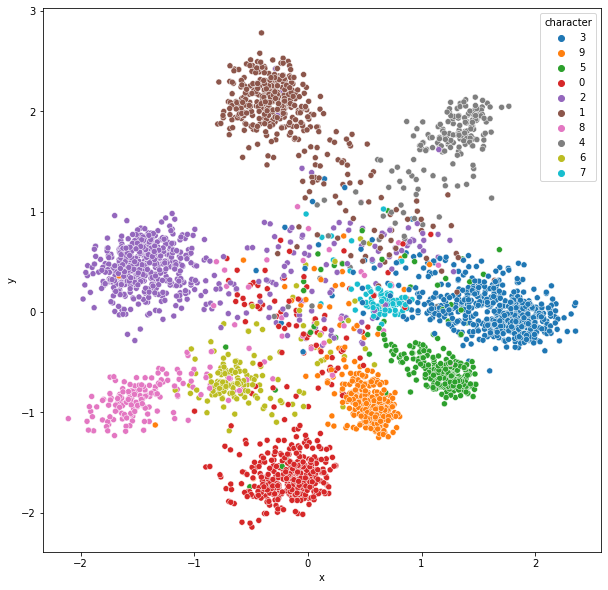

In [119]:
of_interest = [chr(ord('0') + i) for i in range(10)]
m = results_df["character"].isin(of_interest)

plt.figure(figsize=(10, 10))
sns.scatterplot(x='x', y='y', hue='character', data=results_df[m])
plt.show()

In [121]:
clf = neighbors.KNeighborsClassifier(100, weights='uniform')
clf.fit(results_df[["x","y"]], results_df["character"])

KNeighborsClassifier(n_neighbors=100)

In [122]:
ideal_df = results_df.groupby("character")[["x","y"]].median().reset_index()
ideal_df

,character,x,y
0,"""",0.077244,0.083463
1,$,1.285336,0.883076
2,%,0.706501,0.683931
3,&,0.403547,-0.019495
4,',0.203411,0.629519
...,...,...,...
76,£,-0.003757,0.539917
77,¥,-0.166686,0.931293
78,§,-1.595906,-0.961951
79,©,-0.591446,-1.680906


The following code seems to be easier to follow if everything is in dense format (as opposed to sparse).

In [123]:
enc = OneHotEncoder(handle_unknown='ignore')
ideal_as_1hot = enc.fit_transform(ideal_df[["character"]]).todense()

In [124]:
probabilities = clf.predict_proba(ideal_df[["x","y"]])

In [125]:
most_likely = np.multiply(ideal_as_1hot,probabilities)
ideal_df["likelyhood"] = np.amax(most_likely,1)

In [126]:
ideal_df.sort_values("likelyhood").tail(15)

,character,x,y,likelyhood
43,W,0.409597,0.544489,0.45
40,T,-0.592332,0.985694,0.48
52,e,-0.665404,-1.318407,0.49
26,E,0.048873,0.856997,0.61
17,6,-0.626236,-0.697832,0.69
18,7,0.675717,0.086167,0.80
39,S,-0.544060,-0.299559,0.86
11,0,-0.132556,-1.595751,0.86
15,4,1.285730,1.734444,0.90
19,8,-1.432157,-0.811157,0.92


In [132]:
def generate_character(model,x,y):
    s = np.array([x,y])
    s = s.reshape(1,2)
    
    remapped = model.decode(s,apply_sigmoid=True)

    a = (np.array(remapped)*255).astype(np.uint8)
    b = a.reshape((a.shape[1],a.shape[2]))
    ret2,th2 = cv2.threshold(b,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    th2 = 255 - th2
    return th2

def generate_ideal(model,ideal_df,ch):
    r = ideal_df[ideal_df["character"] == ch]
    return generate_character(model,r["x"],r["y"])

Our CVAE handles '4' very well. We have identified some characters which according to our model are 4 but Tessearct thinks differently.

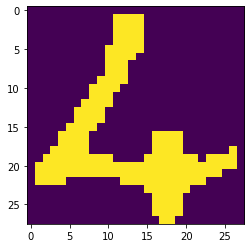

In [134]:
_ = plt.imshow(generate_ideal(base_model,ideal_df,"4"))

Now look at some of the raw characters. Start with characters we think are likely to be 4, but tesseract doesn't.

In [135]:
ideal_df[ideal_df["character"] == "4"]

,character,x,y,likelyhood
15,4,1.28573,1.734444,0.9


In [141]:
actual = enc.transform(results_df[["character"]]).todense()
probabilities = clf.predict_proba(results_df[["x","y"]])
results_df["p"] = probabilities[:,15]

We see that when Tessearct thinks a character is 4, 77% of the time we agree. However, when Tessearct thinks a character is k, 60% we think the character is actaully 4.

In [142]:
results_df.groupby("character")["p"].mean().to_frame().sort_values("p",ascending=False).head()

,p
character,
4,0.74388
k,0.43000
/,0.38500
h,0.35375
%,0.28500


In [143]:
m = results_df["character"] == "k"
results_df[m].sort_values("p",ascending=False).head()

,character,confidence,left,top,right,bottom,max_darkness,fname,area,x,y,p
4159,k,98.799255,3732,5295,3798,5387,90,Bear-AG-29-1940-01-39_ocr_ready.png,6072,1.047137,1.804991,0.83
1187,k,95.982956,1396,8430,1465,8540,97,Bear-AG-29-1940-01-33_ocr_ready.png,7590,0.182587,1.295405,0.03


We see that our classifcation is better than Tessearct's!

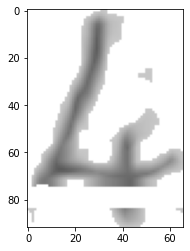

In [145]:
plot_character(results_df,4159)

We see that Tesseract is actually often mislabelling '4's as 'k's. Note that the above 4 is missing a fair bit since it overlaps with a grid line, yet we still estimate the probability of it being a '4' to be 83%/

# Size vs. likelyhood

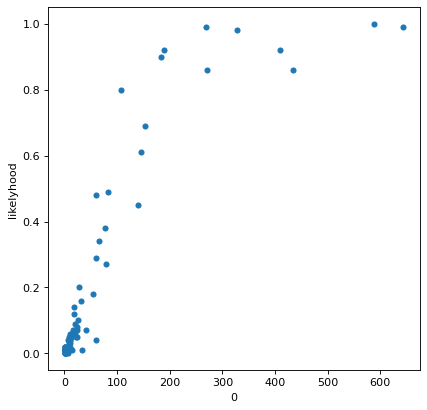

In [146]:
df2 = results_df.groupby("character").size().reset_index()
df3 = ideal_df.merge(df2,on="character")

fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
df3.plot.scatter(x=0,y="likelyhood",ax=ax)
plt.show()